In [52]:
from statsbombpy import sb
import os
import glob
import pandas as pd
import numpy as np
import seaborn.objects as so
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from math import log
import re

In [302]:
skyblue ="#9CC2EA"
burgundy="##960A2C"

def parse_apps(s):
    if pd.isna(s):
        return 0
    # Find main number and optional parens number
    match = re.match(r'(\d+)(?:\((\d+)\))?', s)
    if match:
        main = int(match.group(1))
        parens = int(match.group(2)) if match.group(2) else 0
        return main + parens
    else:
        return 0

player_wages = pd.read_csv("mls-24-fbref-data-may-1/player-wages.csv")
player_wages["weekly_wages"] = (
    player_wages["weekly_wages"].str.extract(r'\$(\d+)')
)
player_wages["annual_wages_stripped"] = (
    player_wages["annual_wages"].str.extract(r'\$(\d+)').astype(float)
)
player_wages["annual_wages"] = (
    player_wages["annual_wages"].str.split(" ").str[0]
)

player_wages["player_norm"] = player_wages["player"].str.strip().str.lower()

ratings_folder_path = 'whoscored_2'
ratings_csv_files = glob.glob(os.path.join(ratings_folder_path, '*.csv'))

df_list = []

for file in ratings_csv_files:
    # only use 2024 data
    if "24" in file:
        df= pd.read_csv(file)
        df_list.append(df)

combined_df = pd.concat(df_list, ignore_index=True)
combined_df["player_norm"] = combined_df["Player"].str.strip().str.lower()

merged_ratings_salary = player_wages.merge(combined_df[['player_norm','Rating', 'Apps']], left_on='player_norm', right_on='player_norm', how='left')
merged_ratings_salary = merged_ratings_salary.dropna(subset=['Rating'])
merged_ratings_salary["weekly_wages"] = merged_ratings_salary["weekly_wages"].astype(float)
merged_ratings_salary["l_weekly"] = np.log(merged_ratings_salary["weekly_wages"].astype(float))
merged_ratings_salary['wages_norm'] = (
    (merged_ratings_salary['weekly_wages'] - merged_ratings_salary['weekly_wages'].min()) / 
    (merged_ratings_salary['weekly_wages'].max() - merged_ratings_salary['weekly_wages'].min())
)
merged_ratings_salary['ratings_norm'] = (
    (merged_ratings_salary['Rating'] - merged_ratings_salary['Rating'].min()) / 
    (merged_ratings_salary['Rating'].max() - merged_ratings_salary['Rating'].min())
)
merged_ratings_salary["value_wage_pen"] = merged_ratings_salary["ratings_norm"] - merged_ratings_salary["wages_norm"]
merged_ratings_salary["value_wage"] = merged_ratings_salary["ratings_norm"] / merged_ratings_salary["wages_norm"]


merged_ratings_salary['total_apps'] = merged_ratings_salary["Apps"].apply(parse_apps)
merged_ratings_salary['is_rapids'] = merged_ratings_salary["team"] == "Colorado Rapids"
merged_ratings_salary['is_dp'] = merged_ratings_salary['annual_wages_stripped'] > 1000000.0
merged_ratings_salary['capped_wages'] = merged_ratings_salary["annual_wages_stripped"].clip(upper=743750.0)

rapids_players = merged_ratings_salary[merged_ratings_salary["team"] == "Colorado Rapids"]

merged_ratings_salary = merged_ratings_salary[merged_ratings_salary["total_apps"] > 17]
merged_ratings_salary = merged_ratings_salary[merged_ratings_salary["wages_norm"] > 0.005]


merged_ratings_salary.head()
# merged_ratings_salary["value_wage"].nlargest(n=10)

,ranker,player,nationality,position,team,age,weekly_wages,annual_wages,notes,annual_wages_stripped,...,Apps,l_weekly,wages_norm,ratings_norm,value_wage_pen,value_wage,total_apps,is_rapids,is_dp,capped_wages
0,1,Lionel Messi,ar ARG,FWMF,Inter Miami,36.0,230769.0,$12000000,NaN,12000000.0,...,16(4),12.349172,1.000000,1.000000,0.000000,1.000000,20,False,True,743750.0
1,2,Sergio Busquets,es ESP,MFDF,Inter Miami,35.0,163461.0,$8499996,NaN,8499996.0,...,27(4),12.004330,0.706586,0.417969,-0.288617,0.591533,31,False,True,743750.0
3,4,Emil Forsberg,se SWE,MF,NY Red Bulls,32.0,103942.0,$5405000,NaN,5405000.0,...,19(4),11.551588,0.447126,0.539062,0.091936,1.205616,23,False,True,743750.0
4,5,Héctor Herrera,mx MEX,MF,Houston Dynamo,33.0,91346.0,$4750000,NaN,4750000.0,...,20(3),11.422410,0.392217,0.476563,0.084346,1.215048,23,False,True,743750.0
5,6,Sebastián Driussi,ar ARG,MFFW,Austin,27.0,86538.0,$4500000,NaN,4500000.0,...,26(1),11.368339,0.371258,0.378906,0.007649,1.020602,27,False,True,743750.0


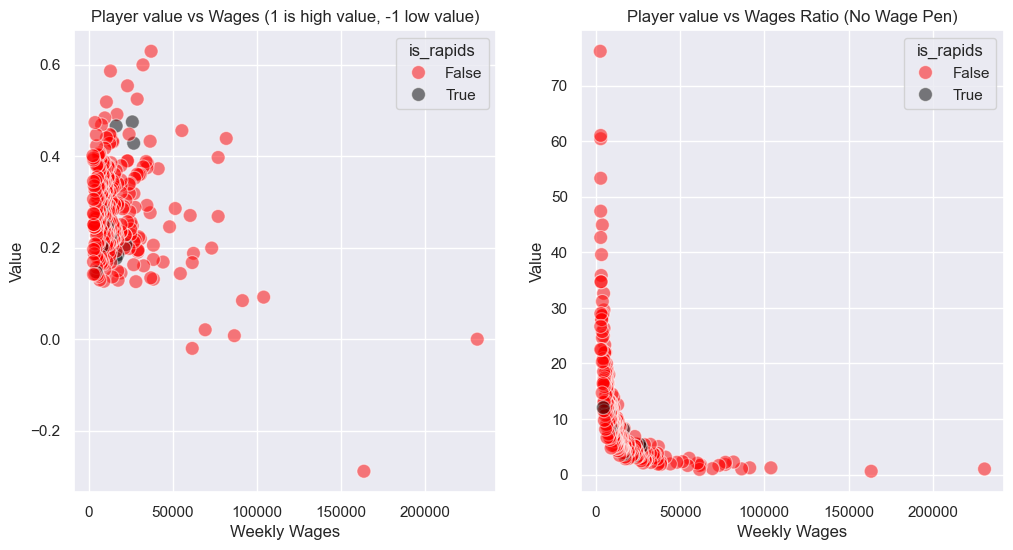

In [303]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

# Draw scatter plot for value vs salary, highlighting rapids players
sns.scatterplot(
    data=merged_ratings_salary, 
    x='weekly_wages', 
    y='value_wage_pen',  
    hue='is_rapids', 
    s=100,
    palette={True:'black', False: 'red'},
    alpha=0.5,
    ax=axes[0]
)
axes[0].set_xlabel("Weekly Wages")
axes[0].set_ylabel("Value")
axes[0].set_title("Player value vs Wages (1 is high value, -1 low value)")
# sns.regplot(data=merged_ratings_salary, x='l_weekly', y='value_wage_pen', ci=95, line_kws={"color": "red"})

sns.scatterplot(
    data=merged_ratings_salary, 
    x='weekly_wages', 
    y='value_wage',  
    hue='is_rapids', 
    s=100,
    palette={True:'black', False: 'red'},
    alpha=0.5,
    ax=axes[1]
)
axes[1].set_xlabel("Weekly Wages")
axes[1].set_ylabel("Value")
axes[1].set_title("Player value vs Wages Ratio (No Wage Pen)")

plt.show()

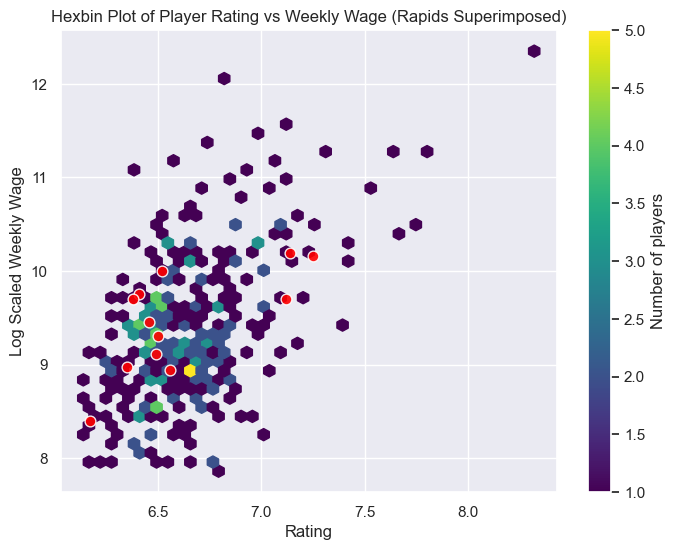

In [304]:
sns.set(style="darkgrid")  # Seaborn styling

plt.figure(figsize=(8, 6))
plt.hexbin(merged_ratings_salary['Rating'], merged_ratings_salary['l_weekly'], gridsize=40, cmap='viridis', mincnt=1)
plt.colorbar(label='Number of players')

highlighted = merged_ratings_salary[merged_ratings_salary['is_rapids'] == True]

plt.scatter(
    highlighted['Rating'],
    highlighted['l_weekly'],
    color='red',
    s=60,
    edgecolor='white',
    label='Rapids Players',
    alpha=0.9
)

plt.xlabel('Rating')
plt.ylabel('Log Scaled Weekly Wage')
plt.title('Hexbin Plot of Player Rating vs Weekly Wage (Rapids Superimposed)')

plt.show()

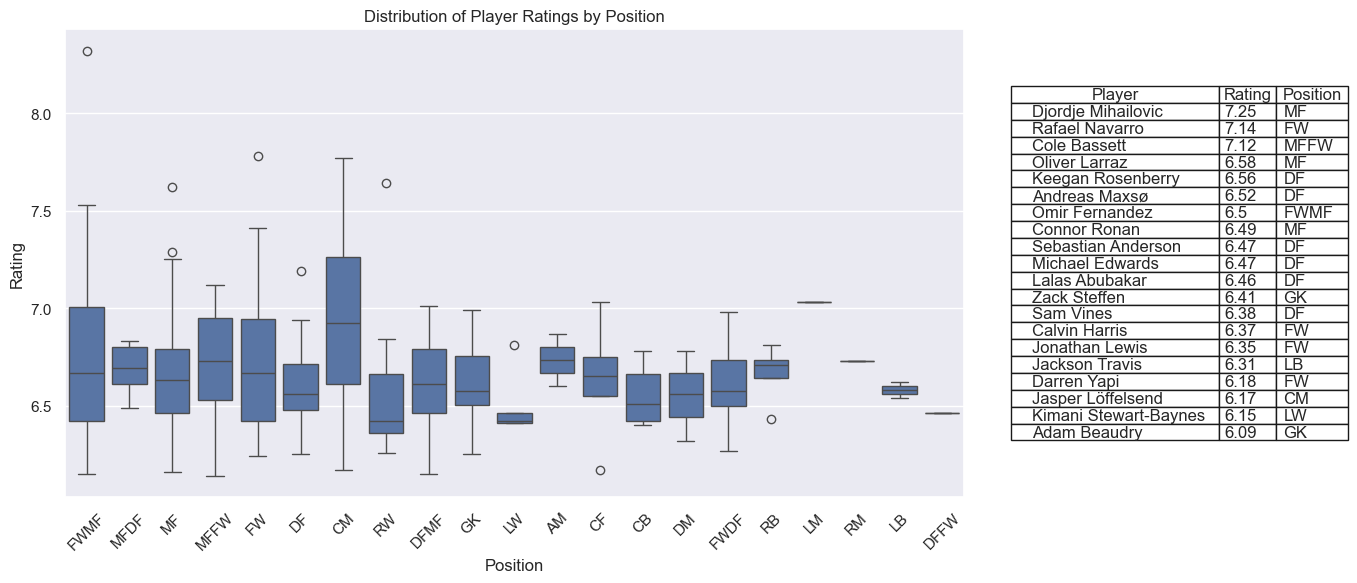

In [305]:
fig, (ax_box, ax_table) = plt.subplots(ncols=2, figsize=(14, 6), gridspec_kw={'width_ratios': [3, 1]})

# Boxplot grouped by Position
sns.boxplot(data=merged_ratings_salary, x='position', y='Rating', ax=ax_box)
ax_box.set_title('Distribution of Player Ratings by Position')
ax_box.set_xlabel('Position')
ax_box.set_ylabel('Rating')
ax_box.tick_params(axis='x', rotation=45)

team_table = rapids_players[["player", "Rating", "position"]].sort_values(by='Rating', ascending=False)

# Hide axes for the table plot
ax_table.axis('off')
ax_table.axis('tight')

# Create the table with the team players and ratings
table = ax_table.table(cellText=team_table.values,
                       colLabels=['Player', 'Rating', 'Position'],
                       cellLoc='left',
                       loc='center')

table.auto_set_font_size(False)
table.set_fontsize(12)
table.auto_set_column_width(col=list(range(len(team_table.columns))))

plt.tight_layout()
plt.show()

In [306]:
from sklearn.linear_model import LinearRegression


X = merged_ratings_salary[["Rating"]]
Y = merged_ratings_salary[["l_weekly"]]

model=LinearRegression()
model.fit(X,Y)

merged_ratings_salary["predicted_wage"] = model.predict(X)
merged_ratings_salary["wage_residual"] = merged_ratings_salary["l_weekly"] - merged_ratings_salary["predicted_wage"]

merged_ratings_salary = merged_ratings_salary.sort_values(by="wage_residual", ascending=False)
merged_ratings_salary[merged_ratings_salary["team"] == "Colorado Rapids"]
#######
rapids_players["predicted_wage"] = model.predict(rapids_players[["Rating"]])
rapids_players["wage_residual"] = rapids_players["l_weekly"] - rapids_players["predicted_wage"]
rapids_players["wage_residual"] = round(rapids_players["wage_residual"],5)

rapids_players = rapids_players.sort_values(by="wage_residual", ascending=False)


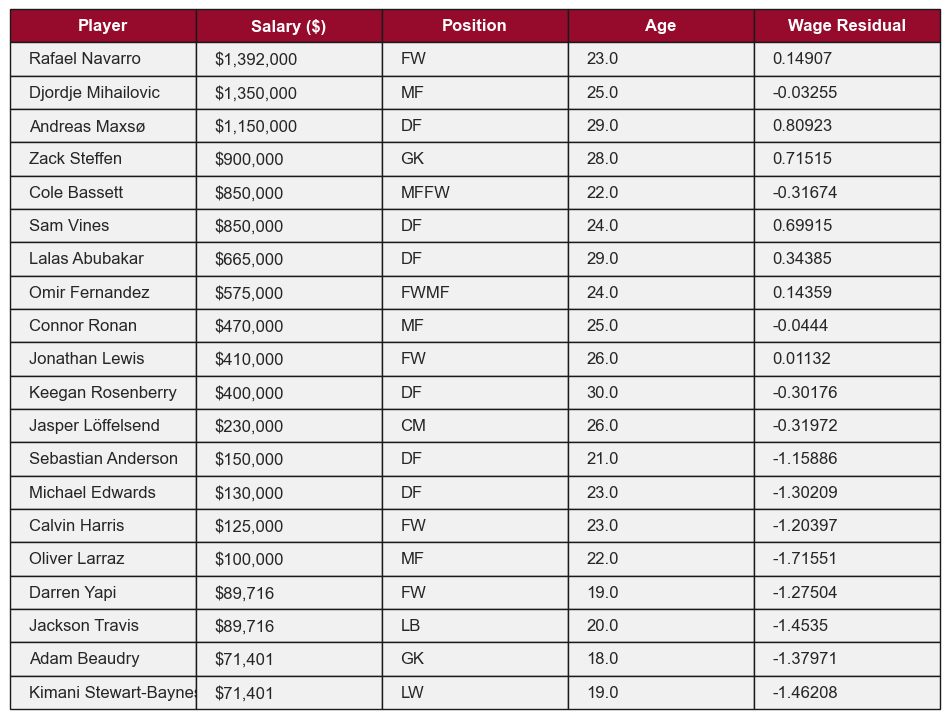

In [307]:
# Current Financial Situation, Player Salaries and Match Ratings of All squad members
rapids_players["annual_wages_stripped"] = rapids_players["annual_wages_stripped"].astype(int)
rapids_players = rapids_players.sort_values(by="annual_wages_stripped", ascending=False)
rapids_players["salary_formatted"] = rapids_players["annual_wages_stripped"].apply(lambda x: f"${x:,.0f}")

rapids_table = rapids_players[["player","salary_formatted","position","age","wage_residual"]]

# rapids_table = rapids_players[["player", "annual_wages","position","age", "wage_residual"]].sort_values(by='annual_wages', ascending=False)

fig, ax = plt.subplots(figsize=(8, 2))  # Adjust size as needed
# Hide axes for the table plot
ax.axis('off')

# Create the table with the team players and ratings
table = ax.table(cellText=rapids_table.values,
                       colLabels=['Player', "Salary ($)", "Position", "Age", "Wage Residual" ],
                       cellLoc='left',
                       loc='center')

table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.5,2)# table.auto_set_column_width(col=list(range(len(rapids_table.columns))))

for (row, col), cell in table.get_celld().items():
    if row == 0:
        cell.set_text_props(weight='bold', color='white')
        cell.set_facecolor('#960A2C')
    else:
        cell.set_facecolor('#f1f1f2')

# plt.tight_layout()
plt.show()

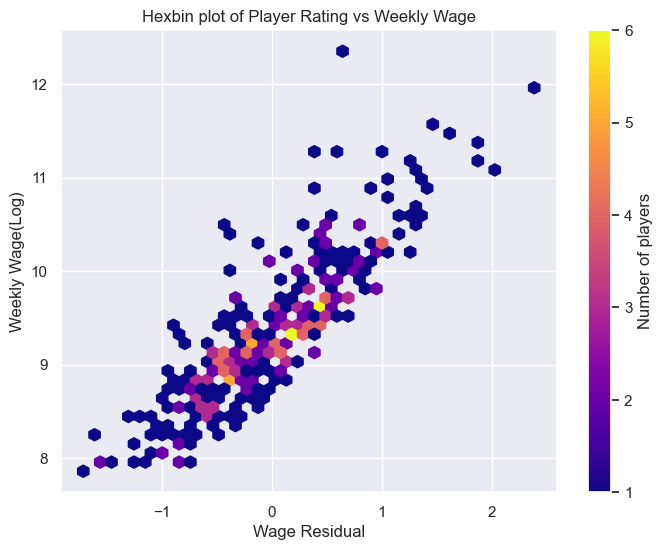

In [308]:
sns.set(style="darkgrid")  # Seaborn styling

plt.figure(figsize=(8, 6))
plt.hexbin(merged_ratings_salary['wage_residual'], merged_ratings_salary['l_weekly'], gridsize=40, cmap='plasma', mincnt=1)
plt.colorbar(label='Number of players')

plt.xlabel('Wage Residual')
plt.ylabel('Weekly Wage(Log)')
plt.title('Hexbin plot of Player Rating vs Weekly Wage')

plt.show()

In [309]:
# Constrained Optimzation
from pulp import LpMaximize, LpProblem, LpVariable, lpSum

# Sample Data
df_current_players = merged_ratings_salary[merged_ratings_salary["is_rapids"] == True]
df_target_players = merged_ratings_salary[merged_ratings_salary["is_rapids"] == False]

current_players = df_current_players.to_dict(orient="records")
transfer_targets = df_target_players.to_dict(orient="records")

# Decision variables
x_current = {p['player']: LpVariable(f"x_{p['player']}", cat='Binary') for p in current_players}
x_target = {p['player']: LpVariable(f"x_{p['player']}", cat='Binary') for p in transfer_targets}
x = {**x_current, **x_target}

# Create the model
model = LpProblem("Roster_Optimization_With_Transfers", LpMaximize)

# Objective function: Maximize total rating - transfer cost penalty
model += (
    lpSum(x[p['player']] * p['Rating'] for p in current_players) 
)

# Constraints
total_budget = 6000000  # $6M cap
model += (
    lpSum(x[p['player']] * p['capped_wages'] for p in current_players)
    <= total_budget
)

model += lpSum(x[p['player']] for p in current_players) >= 8  # Keep at least 2 current players
model += lpSum(x[p['player']] for p in transfer_targets) <= 2  # Max 2 new signings

# Position requirements
model += lpSum(x[p['player']] for p in current_players + transfer_targets if (p['position'] == "DF" or p['position'] == "DFMF")) >= 5
model += lpSum(x[p['player']] for p in current_players + transfer_targets if (p['position'] == "MF" or p['position'] == "FWMF")) >= 8
model += lpSum(x[p['player']] for p in current_players + transfer_targets if p['position'] == "FW") >= 5
model += lpSum(x[p['player']] for p in current_players + transfer_targets if p['position'] == "GK") == 2

# Total roster size
model += lpSum(x[p['player']] for p in current_players + transfer_targets) == 20
model += lpSum(x[p['player']] for p in current_players + transfer_targets if p['is_dp'] == True) <=3

# Solve the model
model.solve()

# Output results
print("Selected Players:")
for p in current_players + transfer_targets:
    if x[p['player']].value() == 1:
        print(f"- {p['player']} ({p['position']}) | Rating: {p['Rating']} | Salary: ${p['capped_wages']:,}")


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/nati/dev/git-repos/aberash-org/rapids-eval/.venv/lib/python3.11/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/lh/hnn_zc990kd0p5ht3_z7nc4m0000gn/T/ac579c2424504cc6b9dbd4893d022b24-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/lh/hnn_zc990kd0p5ht3_z7nc4m0000gn/T/ac579c2424504cc6b9dbd4893d022b24-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 14 COLUMNS
At line 1648 RHS
At line 1658 BOUNDS
At line 1981 ENDATA
Problem MODEL has 9 rows, 322 columns and 977 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Selected Players:
- Andreas Maxsø (DF) | Rating: 6.52 | Salary: $743,750.0
- Zack Steffen (GK) | Ra